In [2]:
import trimesh
import scipy
import numpy as np
import matplotlib.cm as cm
import nibabel as nib
import gdist
import sys
#import meshlabPY
import array2PLY
#import io_AI
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import importlib
import pandas as pd

In [16]:
sys.path.insert(1, "/Users/dvarelat/Documents/MASTER/TFM/methods")
import cardiac_region
importlib.reload(cardiac_region)
import cardiac_region as c

In [5]:
ESPECIMEN = "20190520_E2"
image_path = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/RESULTS/membranes/GASP_PNAS/{ESPECIMEN}_mGFP_XYZ_predictions_GASP.nii.gz"
file_mesh = "mesh_entrada2.ply"
DFFILE = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/EXTRACTION/{ESPECIMEN}/cell_properties.csv"
file_mesh = f"/Users/dvarelat/Documents/MASTER/TFM/midS/{ESPECIMEN}_myo_midS.ply"

In [22]:
df_clean = pd.read_csv(DFFILE)
print(df_clean.shape)
df_clean.head(3)

(3299, 13)


,cell_in_props,volumes,sphericities,original_labels,centroids,lines,axis_major_length,axis_minor_length,nuclei_label_cent,nuclei_cell_in_props,eigenvalues,eigenvectors,eccentricity3d
0,4,3309,0.871308,1791.0,"[130, 191, 144]",0.0,28.884208,12.711425,4580.0,85,"[60.912, 49.794, 27.276]","[[0.993, 0.118, -0.031], [-0.044, 0.588, 0.807...",0.427
1,8,4063,0.732222,1660.0,"[129, 247, 146]",0.0,34.866652,10.443012,4646.0,57,"[100.159, 66.237, 44.827]","[[0.995, -0.014, -0.095], [0.043, -0.817, 0.57...",0.582
2,17,6425,0.724949,2794.0,"[134, 281, 190]",0.0,32.209790,17.945998,8710.0,13,"[82.925, 67.976, 47.155]","[[0.864, -0.466, -0.192], [0.262, 0.09, 0.961]...",0.425


In [11]:
proxy = nib.load(image_path)
img   = np.asarray(proxy.get_fdata(), dtype=proxy.get_data_dtype())

In [12]:
img = img.astype("uint16")

In [13]:
img.shape

(1024, 1024, 493)

In [17]:
dim_info = c.load3D_metadata(image_path)
dim_info

{'x_size': 1024,
 'y_size': 1024,
 'z_size': 493,
 'x_res': 0.757206,
 'y_res': 0.757206,
 'z_res': 0.79905}

In [6]:
mesh = trimesh.load_mesh(file_mesh, process=False)
final_number_faces = 3500
mesh = mesh.simplify_quadratic_decimation(int(final_number_faces))
d = 40

In [15]:
len(mesh.faces)

2999

In [7]:
matrix = gdist.local_gdist_matrix(mesh.vertices, mesh.faces.astype(np.int32), 10)
matrix_ij = scipy.sparse.find(matrix)
matrix_i, matrix_j, distances = matrix_ij[1], matrix_ij[0], matrix_ij[2]

In [8]:
print(len(matrix_j))
print(len(np.unique(matrix_j)))

10032
1865


In [9]:
j_coord = np.asarray(mesh.vertices[matrix_j])
j_coord.shape

(10032, 3)

In [18]:
j_pix = np.floor(j_coord / [dim_info["x_res"], dim_info["y_res"], dim_info["z_res"]]).astype("uint16")
print(j_coord[0])
print(j_pix[0])

[282.53369191 583.66868868 253.77090825]
[373 770 317]


In [19]:
np.max(j_pix, axis=0)

array([600, 915, 321], dtype=uint16)

In [20]:
j_VARIABLE_labels = img[j_pix[:, 0], j_pix[:, 1], j_pix[:, 2]] 

### USAR AQUÍ PROPIEDADD

In [23]:
dict_label_cell = dict(zip(df_clean.original_labels, df_clean.volumes))

In [24]:
len(set(j_VARIABLE_labels))
len(df_clean.original_labels)

3299

### SI ESE LABEL NO ESTÁ EN LA TABLA, SE LE PONE CERO A LA PROPIEDAD

In [25]:
dict_feature = {k:dict_label_cell[k] if k in list(df_clean.original_labels) else 0 for k in set(j_VARIABLE_labels)  }

In [26]:
len(set(j_VARIABLE_labels).intersection(list(df_clean.original_labels)))

482

In [27]:
j_VARIABLE_propiedad = [dict_feature[i] for i in j_VARIABLE_labels]
len(j_VARIABLE_propiedad)

10032

In [133]:
x = [0 for i in j_VARIABLE_propiedad]
import random

randomlist = []
for i in range(0,len(j_VARIABLE_propiedad)):
    n = random.randint(1,30)
    randomlist.append(n)

In [28]:
tight_i = [np.where(matrix_i == i)[0][0] for i in np.unique(matrix_i)]

In [29]:
withme_i_indices = np.split(matrix_j, tight_i)[1:]
thisfar_i = np.split(distances, tight_i)[1:]
withme_i_coord = np.split(j_coord, tight_i)[1:]
withme_i_pix = np.split(j_pix, tight_i)[1:]

In [31]:
#j_VARIABLE_propiedad = randomlist
withme_i_VARIABLE = np.split(j_VARIABLE_propiedad, tight_i)[1:]

In [32]:
VARIABLE_per_i = np.asarray([np.mean(p) for p in withme_i_VARIABLE])  # VALOR MEDIO

all_colors = np.zeros(shape=(mesh.vertices.shape[0], 4), dtype="float64")

colores = array2PLY.colorines(VARIABLE_per_i, cm.jet)

all_colors[np.unique(matrix_i)] = colores

mesh.visual.vertex_colors = all_colors

In [33]:
mesh.export("volumes" + "_" + str(d) + ".ply")

b'ply\nformat binary_little_endian 1.0\ncomment https://github.com/mikedh/trimesh\nelement vertex 1872\nproperty float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nproperty uchar alpha\nelement face 3499\nproperty list uchar int vertex_indices\nend_header\na\xd8\x91C\xf4_\x10De\xe6{C\xff\x91\x00\xff\x85P\x85Cq\xf6\xedC\xee\xbeOC\x00\xd8\xff\xffF\xc2\xb9C\xd40*D\x06\xaamC\xdb\xff\x1c\xff\xca\x82\xdfC\xb8\xc3%D\xf1\x97vC\x00X\xff\xff\xff\\`C\xbf\x02\x98C\x9d3pB\xa4\xffS\xff\xea\xd0_C\x13\x86\x9cC\xc6\x9d\xa8B`\xff\x97\xff\x8b\xd5gC8\x1a\xb1CA\xf7GC\x00\x00\x80\xff}\x06IC\x1d\x18\x9cC=s<C\x004\xff\xff\t\xf9\x8eCv\xa7,Co\x85\xe7B\xad\xffI\xff1\x84\xc4C\xd5\xaf\x06C\xf2\xa7\x9eB\x00\x8c\xff\xffL5\x88C\xf4\x0c\x1dDl[mC\x00\xc0\xff\xff\xe3\xd5iC1\x8d\xddCM`\xffB\x00\x00\x80\xff|L\x99C\n[ D\xb6\xb8YC\x00\xb0\xff\xff9\x9bBCt\xc7ZCM\xb0\x8dB\x00\xdc\xfe\xff\x98\xf3\xcfCP\x91\x1aD\xcc\xc3XC\xb4\xffC\xff\x07\x84qC\xc2\xa8\x0bD\xb1\x8b\x1aC\x

In [ ]:
print(j_coord[0])
print(j_pix[0])

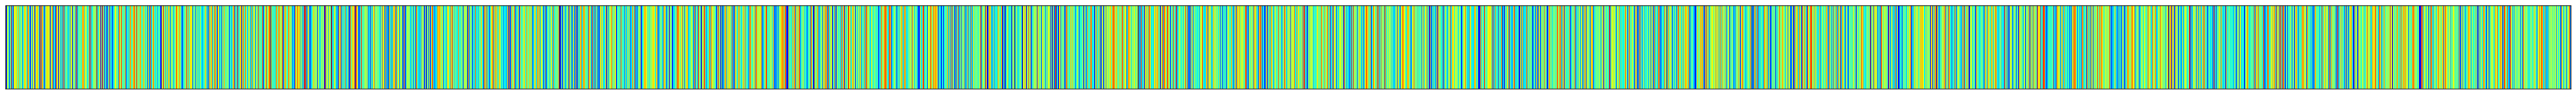

In [98]:
fig, ax = plt.subplots(figsize=(60, 2))
ax.axis(xmin=0, xmax=len(all_colors))
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

for index, colour in enumerate(all_colors):
    ax.axvspan(index, index + 1, color=colour)

# VERIFICAR VOLUMEN

In [80]:
LABELS = np.unique(img)

In [86]:
df_clean = df_clean.sort_values(by=['volumes'])

In [84]:
df_clean.describe()

,cell_in_props,volumes,sphericities,original_labels,lines,axis_major_length,axis_minor_length,nuclei_label_cent,nuclei_cell_in_props,eccentricity3d
count,4811.000000,4811.000000,4811.000000,4811.000000,4811.000000,4811.000000,4811.000000,4811.000000,4811.000000,4811.000000
mean,3300.039701,1754.329453,0.685223,3350.095199,2.029100,20.837920,11.722374,5746.980046,3984.977967,0.335075
std,1939.893644,603.625146,0.067536,1922.599704,2.159152,4.280468,1.734316,5118.187801,3464.785698,0.098232
min,0.000000,336.000000,0.398987,5.000000,0.000000,9.785271,3.942577,-1.000000,-1.000000,0.051000
25%,1597.500000,1307.000000,0.638963,1689.500000,0.000000,17.814169,10.636815,1007.500000,407.000000,0.266000
50%,3290.000000,1716.000000,0.681015,3368.000000,1.000000,20.412970,11.744314,5035.000000,3483.000000,0.336000
75%,4986.000000,2214.000000,0.725369,5015.500000,5.000000,23.295331,12.907758,8758.500000,6951.000000,0.405000
max,6703.000000,2988.000000,1.126783,6716.000000,6.000000,49.353303,17.294204,22955.000000,10730.000000,0.629000


In [89]:
df_clean

,cell_in_props,volumes,sphericities,original_labels,centroids,lines,axis_major_length,axis_minor_length,volumeRGB,sphericityRGB,nuclei_label_cent,nuclei_cell_in_props,eigenvalues,eigenvectors,eccentricity3d
3235,4387,336,0.926638,747.0,"[501, 607, 43]",0.0,11.665724,7.092524,"[0, 2, 253, 255]","[0, 233, 22, 255]",-1.0,-1,"[10.16, 9.32, 5.871]","[[0.942, -0.289, -0.169], [-0.311, -0.942, -0....",0.288
2408,3295,337,0.681918,919.0,"[299, 194, 47]",1.0,11.137594,7.362761,"[0, 2, 253, 255]","[0, 135, 120, 255]",2070.0,4866,"[10.065, 8.913, 6.573]","[[0.992, 0.06, 0.114], [0.044, -0.99, 0.137], ...",0.338
1947,2673,340,0.556553,6052.0,"[241, 278, 174]",5.0,9.987350,8.189313,"[0, 2, 253, 255]","[0, 84, 171, 255]",-1.0,-1,"[9.201, 8.341, 7.567]","[[-0.719, 0.542, -0.436], [0.596, 0.155, -0.78...",0.306
1460,1966,344,0.596563,2422.0,"[189, 414, 77]",5.0,10.569491,8.042380,"[0, 2, 253, 255]","[0, 100, 155, 255]",-1.0,-1,"[9.302, 8.82, 6.95]","[[-0.098, 0.993, 0.065], [-0.995, -0.099, 0.01...",0.228
3592,4966,345,0.701511,4258.0,"[546, 202, 111]",1.0,14.018099,5.777539,"[0, 2, 253, 255]","[0, 143, 112, 255]",-1.0,-1,"[13.675, 11.494, 5.518]","[[0.992, 0.088, 0.087], [0.042, -0.901, 0.432]...",0.399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4235,5892,2981,0.644834,3381.0,"[627, 525, 105]",5.0,30.011494,12.631957,"[0, 14, 241, 255]","[0, 120, 135, 255]",6201.0,9274,"[62.587, 53.013, 25.531]","[[-0.93, -0.367, 0.019], [-0.335, 0.87, 0.362]...",0.391
1026,1355,2982,0.692120,373.0,"[155, 402, 36]",5.0,21.760000,13.336966,"[0, 14, 241, 255]","[0, 139, 116, 255]",1056.0,1671,"[46.68, 32.569, 31.899]","[[0.757, -0.055, -0.651], [0.004, -0.996, 0.08...",0.550
4724,6586,2982,0.641479,5534.0,"[711, 516, 155]",0.0,22.940923,13.775561,"[0, 14, 241, 255]","[0, 118, 137, 255]",12761.0,10528,"[48.444, 35.803, 31.618]","[[-0.811, -0.487, -0.324], [-0.511, 0.859, -0....",0.511
2786,3756,2988,0.721845,494.0,"[417, 255, 42]",1.0,21.759783,14.964218,"[0, 14, 241, 255]","[0, 151, 104, 255]",1569.0,5674,"[40.844, 34.871, 28.366]","[[0.762, 0.406, -0.505], [0.614, -0.702, 0.362...",0.382


## VERIFICAR COORDENADAS

In [31]:
from skimage.morphology import disk, binary_dilation
from skimage import morphology

In [47]:
img.shape

(1024, 1024, 680)

In [54]:
zeros = np.zeros(img.shape)

In [76]:
zeros[j_pix[:, 0], j_pix[:, 1], j_pix[:, 2]] = 1

In [77]:
zeros = binary_dilation(zeros, morphology.ball(radius=4)) 

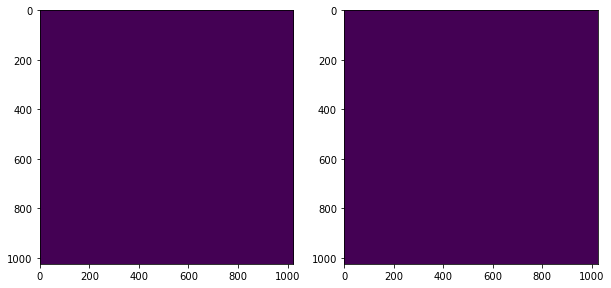

In [78]:
for t in range(68):
    plt.figure(figsize=(10,10)) 
    n = 10*t
    plots = [zeros[:, :, n], img[:, :, n]]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1)
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)

In [79]:
f = '/Users/dvarelat/Documents/MASTER/TFM/DATA/EXTRACTION/20190401_E1/zeros_surface.nii.gz'
c.saveNifti(zeros.astype("uint16"), c.load3D_metadata(image_path), f)